### Simulating the dynamics of a levitated nanoparticle

This notebook will show how to simulate a levitated nanoparticle under the action of a cubic force with delay. To do this we are going to:

* Define an environment where the dynamics of a levitated nanoparticle is considered;
* Generate traces via Euler-Maruyama simulation;
* Making the plots showed in the *Results* section of the paper.

A brief summary of the organization of this notebook:

### Summary

- [1 - Packages and imports](#1)

- [2 - Creating the virtual nano-particle](#2)

- [3 - Generating traces](#3)

- [4 - Plots and comparison with theoretical predictions](#4)

<a name='1'></a> 
### 1. Packages and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from dissertation_codes.environment import Particle
from dissertation_codes.simulation import simulation
import dissertation_codes.utils.constants as ct
from dissertation_codes.utils.parameters import compute_gamma
from scipy import signal as sn

/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/dissertation_codes-0.0.1-py3.8-macosx-10.9-x86_64.egg/dissertation_codes/simulation/simulation_n3d.py:3: NumbaPendingDeprecationWarning: The 'pycc' module is pending deprecation. Replacement technology is being developed.

Pending Deprecation in Numba 0.57.0. For more information please see: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-the-numba-pycc-module


In [2]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

<a name='2'></a> 
### 2. Creating the virtual nano-particle

Here we are going to define some parameters for simulations. First, the particle frequency $f$, from this, we know the period $T$ and the angular frequency $\omega$. The period is going to be used to define the maximum simulation time $t_{max}$. The parameter $M$ represents the number of traces that are going to be created, we will simulate two different gains $G_1=6\times 10^5 \,\textrm{N/m}^3$ and $G_2=2\times 10^5 \,\textrm{N/m}^3$. For this simulation the $\gamma$ used was $66\times 10^3 \textrm{s}^{-1}$.

In [14]:
freq_x = 63.10e3
freq_y = 85.24e3
freq_z = 15.79e3
omega_x = 2*np.pi*freq_x
omega_y = 2*np.pi*freq_y
omega_z = 2*np.pi*freq_z

T = 1 / freq_y
R = 143e-9/2
P = 1e2
max_time = 500 * T
M = 20
delta_t = 1e-8
N_time = int(max_time / delta_t)
t = np.linspace(0, max_time, int(N_time))
gamma = compute_gamma(R, P)

In [15]:
env_x = Particle(omega_x, gamma, radius=R)
env_y = Particle(omega_y, gamma, radius=R)
env_z = Particle(omega_z, gamma, radius=R)

<a name='3'></a> 
### 3. Generating traces

To create the traces we will call a function from our package, the `simulation` will run the Euler-Maruyama algorithm using Numba, this will allow for an optimized run, reducing time consumption. We also defined a `psd` function to run the `welch` method from `scipy.signal` on dictionary of traces.

In [16]:
def psd(traces, delta_t):
    pxxs = []
    for i in range(traces.shape[0]):
        freq, pxx = sn.welch(traces[i,:], fs=1/delta_t, window='hamming', nperseg=int(traces.shape[1]))
        if not np.isnan(pxx.max()) and not pxx.max() > 1e12:
            pxxs.append(pxx)
    return freq, np.array(pxxs)


def generate_traces(env, delta_t, N_time,  M):
    traces = np.zeros(shape=(M, N_time))
    for i in range(M):
        data = simulation(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, 0, 0)
        data = np.array(data)
        traces[i, :] = data
    freq, pxx = psd(env.zp_x*traces, delta_t)
    return env.zp_x*traces, pxx.mean(axis=0), freq

def create_traces(env, delta_t, N_time,  M):
    traces = np.zeros(shape=(M, N_time))
    for i in range(M):
        data = simulation(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, 0, 0)
        data = np.array(data)
        traces[i, :] = data
    return env.zp_x*traces

In [17]:
def lorentzian(omega_array, m, omega, gamma, T=293):
    return (2*gamma*ct.kb*T/m)*(1/(np.power(np.power(omega_array,2)-np.power(omega,2),2)+np.power(omega_array*gamma,2)))

In [18]:
omegas = np.linspace(0, 2*np.pi*1e5, int(1e4))
fit_x = lorentzian(omegas, env_x._m_, omega_x, gamma)
fit_y = lorentzian(omegas, env_x._m_, omega_y, gamma)
fit_z = lorentzian(omegas, env_x._m_, omega_z, gamma)

In [19]:
traces_x  = create_traces(env_x, delta_t, N_time, M)
traces_y  = create_traces(env_y, delta_t, N_time, M)
traces_z  = create_traces(env_z, delta_t, N_time, M)

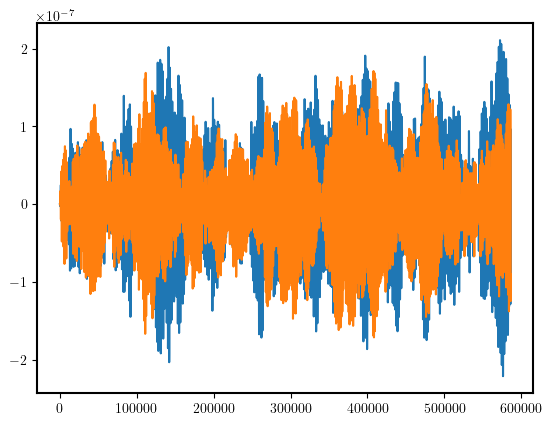

In [20]:
plt.plot(traces_x[0,:])
plt.plot(traces_y[0,:])

In [23]:
c_xxs, c_xys, c_yys = [], [], []
noise_x=10*env_x.zp_x
noise_y=10*env_y.zp_x
shape_traces = traces_x.shape[1]
for i in range(traces_x.shape[0]):
    freq, c_xy = sn.csd(traces_x[i,:], traces_y[i,:], 1/delta_t, nperseg=traces_x.shape[1])
    freq, c_xx = sn.welch(traces_x[i,:], 1/delta_t, nperseg=traces_x.shape[1])
    freq, c_yy = sn.welch(traces_y[i,:], 1/delta_t, nperseg=traces_x.shape[1])
    c_xxs.append(c_xx)
    c_xys.append(c_xy)
    c_yys.append(c_yy)
c_xxs = np.array(c_xxs).mean(axis=0)
c_xys = np.array(c_xys).mean(axis=0)
c_yys = np.array(c_yys).mean(axis=0)



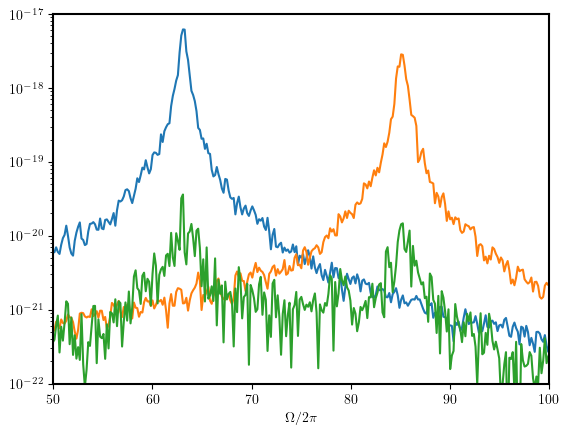

In [26]:
plt.plot(freq/1e3, abs(c_xxs))
plt.plot(freq/1e3, abs(c_yys))
plt.plot(freq/1e3, abs(c_xys))
#plt.plot(freq/1e3, np.sqrt(abs(c_xxs*c_yys)))
plt.xlim([50, 100])
plt.ylim([1e-22, 1e-17])
plt.yscale('log')
plt.xlabel(r'$\Omega/2\pi$')
plt.show()

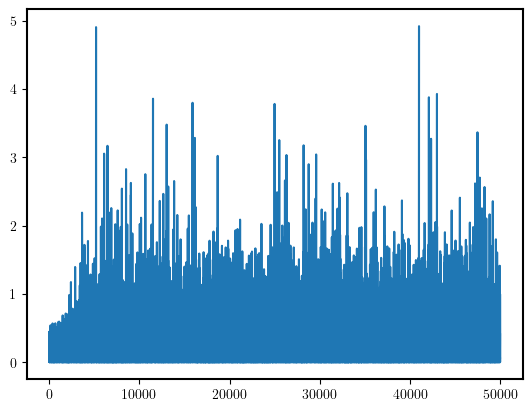

In [128]:
plt.plot(freq/1e3, abs(c_xys)**2/(c_xxs*c_yys))

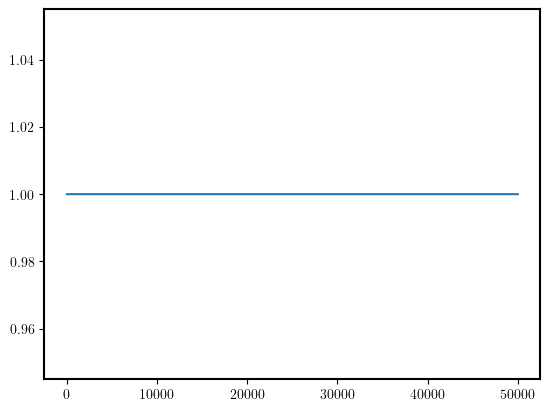

In [125]:
c_xxs, c_xys, c_yys = [], [], []
noise_x=10*env_x.zp_x
noise_y=100*env_y.zp_x
shape_traces = traces_x.shape[1]
for i in range(traces_x.shape[0]):
    freq, c_xy = sn.coherence(traces_x[i,:]+noise_x*np.random.normal(size=shape_traces), 
                              traces_y[i,:]+noise_y*np.random.normal(size=shape_traces), 1/delta_t, nperseg=traces_x.shape[1])
#    freq, c_xx = sn.welch(traces_x[i,:]+noise_x*np.random.normal(size=shape_traces), 1/delta_t, nperseg=traces_x.shape[1])
#    freq, c_yy = sn.welch(traces_y[i,:]+noise_y*np.random.normal(size=shape_traces), 1/delta_t, nperseg=traces_x.shape[1])
#    c_xxs.append(c_xx)
    c_xys.append(c_xy)
#    c_yys.append(c_yy)
#c_xxs = np.array(c_xxs).mean(axis=0)
c_xys = np.array(c_xys).mean(axis=0)
#c_yys = np.array(c_yys).mean(axis=0)

#plt.plot(freq/1e3, abs(c_xxs))
#plt.plot(freq/1e3, abs(c_yys))
plt.plot(freq/1e3, c_xys)
#plt.plot(freq/1e3, np.sqrt(abs(c_xxs*c_yys)))
#plt.xlim([50, 90])
#plt.yscale('log')

In [122]:
c_xys

array([1., 1., 1., ..., 1., 1., 1.])

In [119]:
noise*np.random.normal(size=shape_traces)

array([ 1.57983492e-11,  7.10990170e-11,  4.42281697e-11, ...,
        2.41381275e-11, -8.11676221e-11, -1.00692472e-11])

In [62]:
abs(c_xys).max()/abs(c_yys).max()

0.012797710708788539

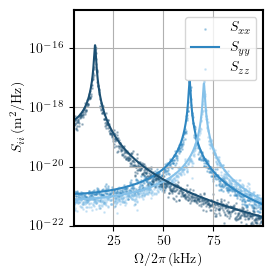

In [10]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
factor = 0.7
fig.set_size_inches(3.5*factor, 4*factor, forward=True)

plt.scatter(freq/1e3, p_xx, color=colors[0], s=1, alpha=0.3)
plt.plot(omegas/(2*np.pi*1e3), np.sqrt(2*np.pi)*fit_x, color=colors[0])
plt.scatter(freq/1e3, p_yy, color=colors[1], s=1, alpha=0.3)
plt.plot(omegas/(2*np.pi*1e3), np.sqrt(2*np.pi)*fit_y, color=colors[1])
plt.scatter(freq/1e3, p_zz, color=colors[2], s=1, alpha=0.3)
plt.plot(omegas/(2*np.pi*1e3), np.sqrt(2*np.pi)*fit_z, color=colors[2])
plt.yscale('log')
plt.xlabel(r'$\Omega/2\pi \,(\textrm{kHz})$')
plt.ylabel(r'$S_{ii} \,(\textrm{m}^2/\textrm{Hz})$')
plt.xlim([5, 100])
plt.ylim([1e-22, 2e-15])
plt.xticks([25, 50, 75])
plt.legend([r'$S_{xx}$', r'$S_{yy}$', r'$S_{zz}$'])
plt.grid()
plt.savefig('../../plots/Chapter 2/psds.pdf', dpi=300, bbox_inches = 'tight')

plt.show()



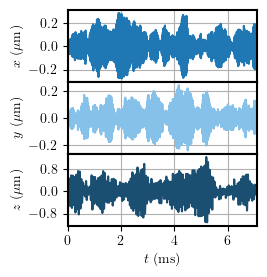

In [20]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
factor = 0.7
fig.set_size_inches(3.5*factor, 4*factor, forward=True)


ax1.plot(t[::10]/1e-3, traces_x[0,:][::10]/1e-6)

ax1.set_xlim([0, t.max()/1e-3])
ax1.set_yticks([-0.2,0,0.2])
ax1.grid(True, which="both", ls="-")
ax1.set_ylabel(r'$x$ $(\mu \textrm{m})$')


ax2.plot(t[::10]/1e-3, traces_y[0,:][::10]/1e-6, color=colors[1])
ax2.set_ylabel(r'$y$ $(\mu \textrm{m})$')
ax2.grid(True, which="both", ls="-")
ax2.set_yticks([-0.2,0,0.2])


ax3.plot(t[::10]/1e-3, traces_z[0,:][::10]/1e-6, color=colors[2])
ax3.set_yticks([-0.8,0,0.8])
ax3.set_ylabel(r'$z$ $(\mu \textrm{m})$')
ax3.set_xlabel(r'$t$ (ms)')
plt.subplots_adjust(wspace=0, hspace=0)

plt.grid()
plt.savefig('../../plots/Chapter 2/traces.pdf', dpi=300, bbox_inches = 'tight')
plt.show()
